# Introduction

### Problem Description

In this presentation, some toy classification problems are studied. Their common property is that raw features to be used form inefficient representations, while a bit of feature engineering can result in guaranteed perfect scores. However, for the sake of curiosity, here features are not transformed and it is measured how well Gradient Boosting can predict class labels based on initial representations.

### Software Requirements

This notebook does not use any packages beyond a list of those that are quite popular in scientific computing. Use conda or pip to install any of them.

# General Preparations

In [1]:
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import mpl_toolkits.mplot3d.axes3d as axes3d

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Startup settings can not suppress a warning from `xgboost` and so this is needed.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import xgboost as xgb

In [2]:
np.random.seed(361)

# Concentric Spheres

This binary classification problem is very simple. There are several concentric (probably, high-dimensional) spheres and each of them is associated with one class only. This means that radius (i.e. distance between a point and the common center of all spheres) is a "golden feature" — a classifier trained only on it can achieve superior accuracy.

Nevertheless, the question is what `xgboost` is able to achieve if it is applied in a naive straightforward fashion without radius computation.

In [3]:
def draw_from_unit_sphere(sample_size, n_dim):
    """
    Draws `sample_size` random samples
    from uniform distribution on
    `n_dim`-dimensional unit sphere.
    
    The idea is to draw samples from an
    isotropic distribution (here, normal
    distribution) and then norm them.
    
    @type sample_size: int
    @type n_dim: int
    @return: numpy.ndarray
    """
    normal_sample = np.random.normal(size=(sample_size, n_dim))
    radii = np.sqrt((normal_sample ** 2).sum(axis=1))
    radii = radii.reshape((radii.shape[0], 1))
    return normal_sample / radii

Let us show that the above function works.

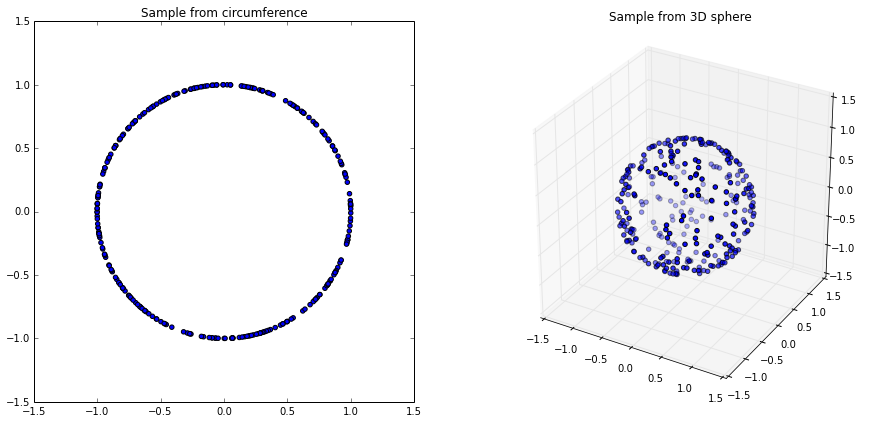

In [4]:
sample_size = 300
circumference = draw_from_unit_sphere(sample_size, 2)
three_d_sphere = draw_from_unit_sphere(sample_size, 3)

fig = plt.figure(figsize=(15, 8))

ax_one = fig.add_subplot(121)
ax_one.scatter(circumference[:, 0], circumference[:, 1])
ax_one.set_aspect('equal')
ax_one.set_title("Sample from circumference")

ax_two = fig.add_subplot(122, projection='3d')
ax_two.scatter(three_d_sphere[:, 0], three_d_sphere[:, 1], three_d_sphere[:, 2])
ax_two.set_aspect('equal')
_ = ax_two.set_title("Sample from 3D sphere", y=1.075)

In [5]:
def draw_from_concentric_spheres(radii, n_dim, samples_per_sphere):
    """
    @type radii: list(float)
    @type n_dim: int
    @type samples_per_sphere: int
    @return: numpy.ndarray
    """
    spheres = []
    for radius in radii:
        spheres.append(radius * draw_from_unit_sphere(samples_per_sphere, n_dim))
    spheres = np.vstack(spheres)
    return spheres

In [6]:
def synthesize_nested_spheres_dataset(radii_of_positives, radii_of_negatives,
                                      n_dim, samples_per_sphere):
    """
    Creates dataset for a binary classification
    problem, where objects are drawn from
    concentric spheres and distance from the
    origin determines the class of an object.
    
    @type radii_of_positives: list(float)
    @type radii_of_negatives: list(float)
    @type n_dim: int
    @type samples_per_sphere: int
    @return: numpy.ndarray
    """
    positives = draw_from_concentric_spheres(radii_of_positives, n_dim,
                                             samples_per_sphere)
    positives = np.hstack((positives, np.ones((positives.shape[0], 1))))
    negatives = draw_from_concentric_spheres(radii_of_negatives, n_dim,
                                             samples_per_sphere)
    negatives = np.hstack((negatives, np.zeros((negatives.shape[0], 1))))
    dataset = np.vstack((positives, negatives))
    return dataset

In [11]:
def eveluate_xgboost_performance(dataset):
    """
    @type dataset: numpy.ndarray
    @return: float
    """
    # Prepare data.
    X_refit, X_test, y_refit, y_test = \
        train_test_split(dataset[:, :-1], dataset[:, -1],
                         stratify=dataset[:, -1], random_state=361)
    X_train, X_val, y_train, y_val = \
        train_test_split(X_refit, y_refit,
                         stratify=y_refit, random_state=361)
    dm_refit = xgb.DMatrix(X_refit, label=y_refit)
    dm_train = xgb.DMatrix(X_train, label=y_train)
    dm_val = xgb.DMatrix(X_val, label=y_val)
    dm_test = xgb.DMatrix(X_test, label=y_test)
    
    # Set hyperparameters.
    num_rounds = 3000
    hyperparams = {'max_depth': 10,  # Decision stumps work poorly here.
                   'subsample': 0.9,
                   'objective': 'binary:logistic'}
    early_stopping_rounds = 10
    learning_rates = [0.3] * 1000 + [0.2] * 1000 + [0.1] * 1000

    # Train model.
    bst = xgb.train(hyperparams, dm_train, num_rounds,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=[(dm_train, 'train'), (dm_val, 'valid')],
                    learning_rates=learning_rates,
                    verbose_eval=500)
    num_rounds = bst.best_iteration
    learning_rates = learning_rates[:num_rounds]
    bst = xgb.train(hyperparams, dm_refit, num_rounds,
                    evals=[(dm_refit, 'refit')],
                    learning_rates=learning_rates,
                    verbose_eval=500)
    
    # Evaluate performance.
    y_hat = bst.predict(dm_test)
    score = roc_auc_score(y_test, y_hat)
    return score

Settings of the experiment are introduced in the below cell. It is possible to change them in order to see what happens.

In [12]:
positive_radii = [10, 12, 14]
negative_radii = [11, 13]

dims = [2, 3, 4, 5, 6]
base_sizes = [250, 500, 1000, 2000]
curse_adjustment_factor = 4  # Compensate curse of dimensionality.

In [13]:
scores = []
for n_dim, sample_size in product(dims, base_sizes):
    print('\n---')
    print("Dimensionality is {}, base size is {}".format(n_dim, sample_size))
    adjusted_size = (curse_adjustment_factor ** (n_dim - 2)) * sample_size
    dataset = synthesize_nested_spheres_dataset(positive_radii, negative_radii,
                                                n_dim, adjusted_size)
    score = eveluate_xgboost_performance(dataset)
    scores.append({'n_dim': n_dim, 'sample_size': sample_size, 'score': score})
    
scores_df = pd.DataFrame(scores)
scores_df


---
Dimensionality is 2, base size is 100

---
Dimensionality is 2, base size is 500


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.174377	valid-error:0.393617
Stopping. Best iteration:
[23]	train-error:0.024911	valid-error:0.265957

[0]	refit-error:0.165333
[22]	refit-error:0.026667
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.264580	valid-error:0.287846
Stopping. Best iteration:
[43]	train-error:0.000711	valid-error:0.072495

[0]	refit-error:0.294933
[42]	refit-error:0.000000
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.286273	valid-error:0.292111
Stopping. Best iteration:
[36]	train-error:0.000000	valid-error:0.029851

[0]	refit-error:0.282667
[35]	refit-error:0.000000
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.265244	valid-error:0.278933



---
Dimensionality is 2, base size is 1000

---
Dimensionality is 2, base size is 2000


Stopping. Best iteration:
[43]	train-error:0.000000	valid-error:0.001067

[0]	refit-error:0.298133
[42]	refit-error:0.000000
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.312000	valid-error:0.424000
Stopping. Best iteration:
[0]	train-error:0.312000	valid-error:0.424000




---
Dimensionality is 3, base size is 100

---
Dimensionality is 3, base size is 500


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.389867	valid-error:0.398933
Stopping. Best iteration:
[48]	train-error:0.046400	valid-error:0.279467

[0]	refit-error:0.384267
[47]	refit-error:0.062267
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.385511	valid-error:0.394400



---
Dimensionality is 3, base size is 1000


Stopping. Best iteration:
[84]	train-error:0.017600	valid-error:0.191467

[0]	refit-error:0.384867
[83]	refit-error:0.021867
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.387511	valid-error:0.388267



---
Dimensionality is 3, base size is 2000


Stopping. Best iteration:
[109]	train-error:0.014444	valid-error:0.113467

[0]	refit-error:0.387300
[108]	refit-error:0.021333
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.351111	valid-error:0.431333
Stopping. Best iteration:
[5]	train-error:0.246444	valid-error:0.411333

[0]	refit-error:0.387167
[4]	refit-error:0.312833
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.400000	valid-error:0.400000



---
Dimensionality is 4, base size is 100

---
Dimensionality is 4, base size is 500


Stopping. Best iteration:
[68]	train-error:0.119778	valid-error:0.354533

[0]	refit-error:0.400000
[67]	refit-error:0.134833
Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.400000	valid-error:0.400000



---
Dimensionality is 4, base size is 1000


Stopping. Best iteration:
[99]	train-error:0.108044	valid-error:0.309133

[0]	refit-error:0.399967
[98]	refit-error:0.131650



---
Dimensionality is 4, base size is 2000


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.400000	valid-error:0.400000
Stopping. Best iteration:
[357]	train-error:0.018389	valid-error:0.226033

[0]	refit-error:0.399858
[356]	refit-error:0.028525



---
Dimensionality is 5, base size is 100


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.399611	valid-error:0.401000
Stopping. Best iteration:
[0]	train-error:0.399611	valid-error:0.401000




---
Dimensionality is 5, base size is 500


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.399122	valid-error:0.399933
Stopping. Best iteration:
[39]	train-error:0.288267	valid-error:0.387167

[0]	refit-error:0.399592
[38]	refit-error:0.307642



---
Dimensionality is 5, base size is 1000


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.399722	valid-error:0.399950
Stopping. Best iteration:
[42]	train-error:0.320006	valid-error:0.379867

[0]	refit-error:0.399617
[41]	refit-error:0.336983



---
Dimensionality is 5, base size is 2000


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.399717	valid-error:0.399900
Stopping. Best iteration:
[54]	train-error:0.324578	valid-error:0.370992

[0]	refit-error:0.399371
[53]	refit-error:0.335906



---
Dimensionality is 6, base size is 100


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.399403	valid-error:0.400792
Stopping. Best iteration:
[6]	train-error:0.395556	valid-error:0.399500

[0]	refit-error:0.399687
[5]	refit-error:0.398562



---
Dimensionality is 6, base size is 500


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.399542	valid-error:0.399883
Stopping. Best iteration:
[56]	train-error:0.331767	valid-error:0.393600

[0]	refit-error:0.399550
[55]	refit-error:0.342746



---
Dimensionality is 6, base size is 1000


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.399582	valid-error:0.399763
Stopping. Best iteration:
[60]	train-error:0.353149	valid-error:0.386900

[0]	refit-error:0.399804
[59]	refit-error:0.360678



---
Dimensionality is 6, base size is 2000


Will train until valid error hasn't decreased in 10 rounds.
[0]	train-error:0.399838	valid-error:0.399987
Stopping. Best iteration:
[64]	train-error:0.362601	valid-error:0.385908

[0]	refit-error:0.399838
[63]	refit-error:0.367326


,n_dim,sample_size,score
0,2,100,0.749333
1,2,500,0.981899
2,2,1000,0.999640
3,2,2000,0.999993
4,3,100,0.500000
5,3,500,0.805933
6,3,1000,0.922749
7,3,2000,0.967585
8,4,100,0.555180
9,4,500,0.715981


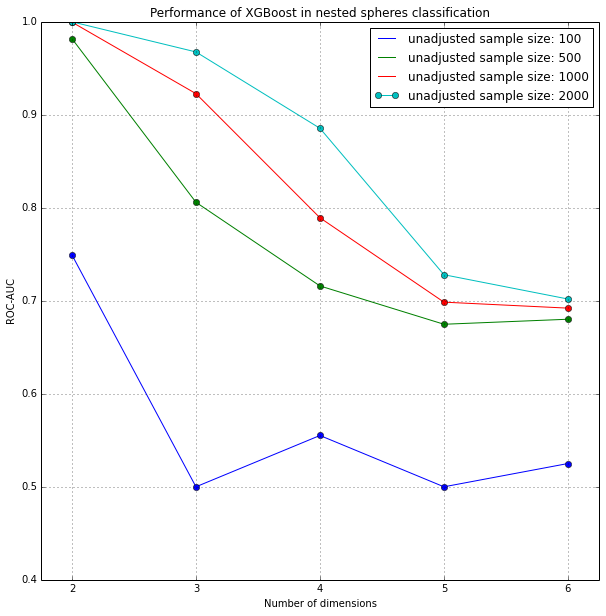

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for idx, group in scores_df.groupby(['sample_size']):
    name_for_legend = 'unadjusted sample size: {}'.format(idx)
    group[name_for_legend] = group['score']
    group.plot('n_dim', name_for_legend, ax=ax, marker='o')
ax.set_xlim(min(dims) - 0.25, max(dims) + 0.25)
ax.grid(True)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('ROC-AUC')
_ = ax.set_title('Performance of XGBoost in nested spheres classification')

# Nested Surfaces of Revolution Based on Spheres

This binary classification problem is a bit more involved. There are several $n$-dimensional nested shapes that are surfaces of revolution constructed by rotation of (hyper)spheres of different radii (called minor radii) along a circumference of a fixed radius (called major radius) centered at the origin. For example, if $n$ = 3, the shapes are nested tori.

Again, each shape is associated with one class only. Thus, a "golden feature" is distance between a point and the circumference of revolution. However, like in the previous problem, only coordinates in $n$-dimensional space are used.

In [45]:
def draw_from_surface_of_sphere_revolution(major_radius, minor_radius,
                                           n_dim, sample_size):
    """
    Draws `sample_size` random samples
    from uniform distribution on
    `n_dim`-dimensional surface of
    revolution of hypersphere.
    
    This hypersphere has radius equal to
    `minor_radius`, while the circumference
    of revolution has radius `major_radius`
    and lies within a linear span of the
    first two orts.
    
    @type major_radius: float
    @type minor_radius: float
    @type n_dim: int
    @type sample_size: int
    @return: numpy.ndarray
    """
    try:
        assert n_dim > 2
    except AssertionError:
        raise ValueError("Number of dimensions must be 3 or greater.")
    try:
        assert major_radius > minor_radius
    except AssertionError:
        raise ValueError("Major radius must be greater than minor radius.")

    revolution_part = draw_from_unit_sphere(sample_size, 2)
    sphere_part = draw_from_unit_sphere(sample_size, n_dim - 1)
    xy_coefficients = major_radius + minor_radius * sphere_part[:, 0]
    xy_coefficients = xy_coefficients.reshape((xy_coefficients.shape[0], 1))
    projection_on_xy =  xy_coefficients * revolution_part
    projection_on_other_axes = sphere_part[:, 1:]
    return np.hstack((projection_on_xy, projection_on_other_axes))

Let us show that the above function works. Why not to draw a sample from torus?

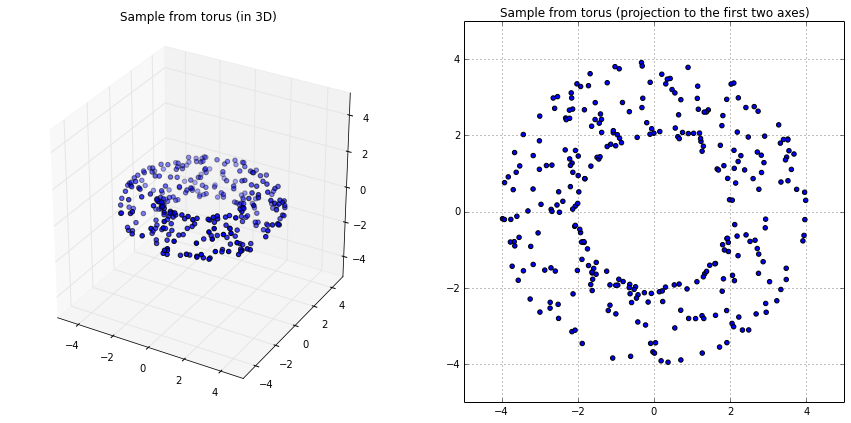

In [46]:
torus = draw_from_surface_of_sphere_revolution(major_radius=3, minor_radius=1,
                                               n_dim=3, sample_size=300)

fig = plt.figure(figsize=(15, 8))

ax_one = fig.add_subplot(121, projection='3d')
ax_one.scatter(torus[:, 0], torus[:, 1], torus[:, 2])
ax_one.set_aspect('equal')  # It does not work properly, so below is hack.
ax_one.set_zlim(torus[:, 0].min() - 1, torus[:, 0].max() + 1)
ax_one.set_title("Sample from torus (in 3D)", y=1.075)

ax_two = fig.add_subplot(122)
ax_two.scatter(torus[:, 0], torus[:, 1])
ax_two.set_aspect('equal')
ax_two.grid(True)
_ = ax_two.set_title("Sample from torus (projection on the first two axes)")

In [ ]:
def draw_from_nested_surfaces_of_sphere_revolution(major_radius, minor_radii,
                                                   n_dim, samples_per_surface):
    """
    Draws from uniform distributions on
    nested surfaces of revolution. 
    
    @type major_radius: float
    @type minor_radii: list(float)
    @type n_dim: int
    @type samples_per_surface: int
    @return: numpy.ndarray
    """
    surfaces = []
    for minor_radius in minor_radii:
        surfaces.append(
            draw_from_surface_of_sphere_revolution(major_radius, minor_radius,
                                                   n_dim, samples_per_surface))
    surfaces = np.vstack(surfaces)
    return surfaces

In [ ]:
def synthesize_nested_surfaces_of_revolution(major_radius,
                                             radii_of_positives, radii_of_negatives,
                                             n_dim, samples_per_surface):
    """
    Creates dataset for a binary classification
    problem, where objects are drawn from
    nested surfaces of revolution and distance
    between a point and the circumference of
    revolution determines the class of the point.
    
    @type major_radius: float
    @type radii_of_positives: list(float)
    @type radii_of_negatives: list(float)
    @type n_dim: int
    @type samples_per_surface: int
    @return: numpy.ndarray
    """
    positives = draw_from_nested_surfaces_of_sphere_revolution(
        major_radius, radii_of_positives, n_dim, samples_per_surface)
    positives = np.hstack((positives, np.ones((positives.shape[0], 1))))
    negatives = draw_from_nested_surfaces_of_sphere_revolution(
        major_radius, radii_of_negatives, n_dim, samples_per_surface)
    negatives = np.hstack((negatives, np.zeros((negatives.shape[0], 1))))
    dataset = np.vstack((positives, negatives))
    return dataset

Settings of the experiment are introduced in the below cell. It is possible to change them in order to see what happens.

In [ ]:
major_radius = 100
positive_radii = [10, 12, 14]
negative_radii = [11, 13]

dims = [2, 3, 4, 5, 6]
base_sizes = [250, 500, 1000, 2000]
curse_adjustment_factor = 4  # Compensate curse of dimensionality.

In [ ]:
scores = []
for n_dim, sample_size in product(dims, base_sizes):
    print('\n---')
    print("Dimensionality is {}, base size is {}".format(n_dim, sample_size))
    adjusted_size = (curse_adjustment_factor ** (n_dim - 2)) * sample_size
    dataset = synthesize_nested_surfaces_of_revolution(
        major_radius, positive_radii, negative_radii, n_dim, adjusted_size)
    score = eveluate_xgboost_performance(dataset)
    scores.append({'n_dim': n_dim, 'sample_size': sample_size, 'score': score})
    
scores_df = pd.DataFrame(scores)
scores_df

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for idx, group in scores_df.groupby(['sample_size']):
    name_for_legend = 'unadjusted sample size: {}'.format(idx)
    group[name_for_legend] = group['score']
    group.plot('n_dim', name_for_legend, ax=ax, marker='o')
ax.set_xlim(min(dims) - 0.25, max(dims) + 0.25)
ax.grid(True)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('ROC-AUC')
_ = ax.set_title('Performance of XGBoost in classification of points from ' +
                 'nested surfaces of revolution')

# Conclusion

To be continued.